# "NBA Shot Chart  "     
## LeBron James
## 데뷔초창기 르브론과 현재 르브론의 슛 분포는 어떻게 다를까?
### 르브론 제임스의 데뷔2년차 vs 19-20시즌 shot chart 비교 (실습 및 분석)

#### 필요한 library , module 다운로드   
open nba API 에서 다양한 dataset 활용가능

In [18]:
# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players   #should install nba_api module
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats import endpoints
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

개별 선수들의 슛 관련 지표를 확인할 수 있는 함수 생성

In [19]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: 선수이름
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]


In [20]:
player_shotchart_df1, league_avg = get_player_shotchartdetail('LeBron James', '2004-05')
player_shotchart_df2, league_avg = get_player_shotchartdetail('LeBron James', '2019-20')

In [21]:
player_shotchart_df1.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020400006,15,2544,LeBron James,1610612739,Cleveland Cavaliers,1,9,13,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,87,155,1,0,20041103,CLE,IND
1,Shot Chart Detail,0020400006,48,2544,LeBron James,1610612739,Cleveland Cavaliers,1,5,25,Made Shot,Finger Roll Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-21,10,1,1,20041103,CLE,IND
2,Shot Chart Detail,0020400006,57,2544,LeBron James,1610612739,Cleveland Cavaliers,1,4,14,Made Shot,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,15,-154,-18,1,1,20041103,CLE,IND
3,Shot Chart Detail,0020400006,59,2544,LeBron James,1610612739,Cleveland Cavaliers,1,3,35,Made Shot,Finger Roll Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,15,7,1,1,20041103,CLE,IND
4,Shot Chart Detail,0020400006,89,2544,LeBron James,1610612739,Cleveland Cavaliers,1,0,30,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,16,126,102,1,0,20041103,CLE,IND


In [22]:
player_shotchart_df1['LOC_X'].isnull().any().any() #누락된 데이터 없는지 확인

False

##  draw court function

코트 그리는 함수 생성   
 골대를 (0,0), center point는 (-220,0)를 좌표로 함

In [30]:

def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):
  
    """
      Parameters 변수설명
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If `True` it draws the out of bound lines in same style as the rest of
        the court.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """
    if ax is None:
        ax = plt.gca()

    # NBA 규격의 코트에 있는 각각의 요소들 생성 - 골대, 페인트존, 제한구역 등

    # Create the basketball hoop 
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    # Create backboard 
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)
    # The paint 
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft 
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

## shot chart function   
NBA shot chart와 동일한 chart 만들어내는 함수 생성   
슛이 성공한 지점은 초록색 원으로 표시되고 실패한 지점은 빨간색 X로 표현됨

In [25]:
def shot_chart(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="blue",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    # separate color by make or miss    
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']

    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']

    # plot missed shots
    ax.scatter(x_missed, y_missed, c='r', marker="x", s=300, linewidths=3, **kwargs)
    # plot made shots
    ax.scatter(x_made, y_made, facecolors='none', edgecolors='g', marker="o", s=100, linewidths=3, **kwargs)
        
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

In [26]:
# 차트 크기지정
plt.rcParams['figure.figsize'] = (12, 11)

## Cleveland  2003-04 (위) vs LA  2019-20 (아래)

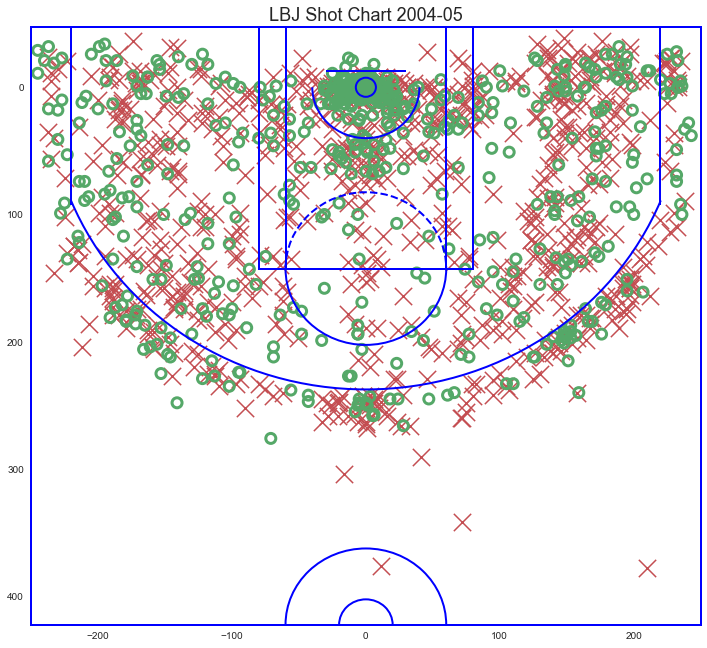

FG%:  0.472 (795-1684)


In [27]:
shot_chart(player_shotchart_df1, title="LBJ Shot Chart 2004-05")
plt.show()
print("FG%: ", "{0:.3f}".format(player_shotchart_df1['SHOT_MADE_FLAG'].sum()/len(player_shotchart_df1)), "({0}-{1})".format(player_shotchart_df1['SHOT_MADE_FLAG'].sum(),len(player_shotchart_df1)))

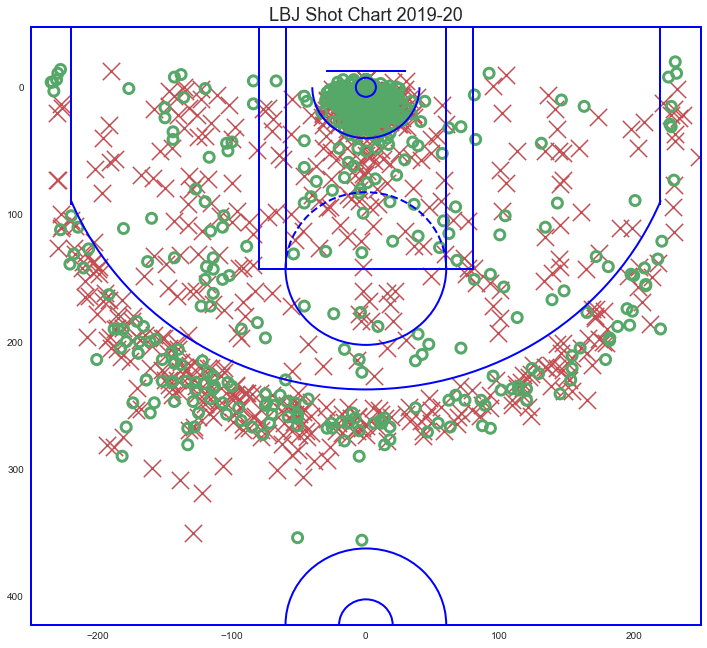

FG%:  0.493 (643-1303)


In [28]:
shot_chart(player_shotchart_df2, title="LBJ Shot Chart 2019-20")
plt.show()
print("FG%: ", "{0:.3f}".format(player_shotchart_df2['SHOT_MADE_FLAG'].sum()/len(player_shotchart_df2)), "({0}-{1})".format(player_shotchart_df2['SHOT_MADE_FLAG'].sum(),len(player_shotchart_df2)))

### 차이점   
* 슛 시도 횟수가 1684 -> 1303으로 감소
* FG% (슛 성공률) 은 0.472 -> 0.493으로 증가
* 과거에 비해 원거리 2점슛에 비해 3점을 쏘는 비율이 높아졌고 3점라인 보다 훨씬 멀리서 쏘는 deep three 또한 많이 시도하고 있음을 확인할 수 있다

----------------------------------

## 실제로 FG%와 3점슛 양상이 어떻게 달라졌는지 살펴보자!   
지표 가져오기

In [29]:
career_lbj = playercareerstats.PlayerCareerStats(player_id = '2544')
career_lbj_df = career_lbj.get_data_frames()[0]
career_lbj_df.head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,2003-04,00,1610612739,CLE,19.0,79,79,3120.0,622,1492,0.417,63,217,0.290,347,460,0.754,99,333,432,465,130,58,273,149,1654
1,2544,2004-05,00,1610612739,CLE,20.0,80,80,3388.0,795,1684,0.472,108,308,0.351,477,636,0.750,111,477,588,577,177,52,262,146,2175
2,2544,2005-06,00,1610612739,CLE,21.0,79,79,3361.0,875,1823,0.480,127,379,0.335,601,814,0.738,75,481,556,521,123,66,260,181,2478
3,2544,2006-07,00,1610612739,CLE,22.0,78,78,3190.0,772,1621,0.476,99,310,0.319,489,701,0.698,83,443,526,470,125,55,250,171,2132
4,2544,2007-08,00,1610612739,CLE,23.0,75,74,3027.0,794,1642,0.484,113,359,0.315,549,771,0.712,133,459,592,539,138,81,255,165,2250


## NBA 입성 초반부터 FG%은 어떤 양상으로 변화했을까?      
lbj_fg_pct : 평균 슛 성공률   
matplotlib을 활용한 FG%그래프 생성

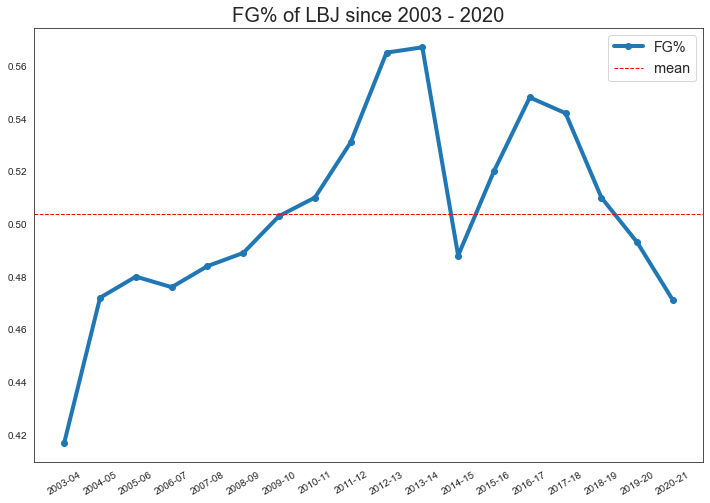

In [15]:
lbj_fg_pct = career_lbj_df['FG_PCT']
lbj_season = list(career_lbj_df['SEASON_ID'])
lbj_fg_pct_mean = lbj_fg_pct.mean()

plt.figure(figsize=(12,8))
plt.plot(lbj_season,lbj_fg_pct,'-p',linewidth=4, marker = 'o')
plt.axhline(y=lbj_fg_pct_mean, color='red', linestyle='--', linewidth=1)
plt.title('FG% of LBJ since 2003 - 2020', fontsize = 20)
plt.xticks(rotation=30) #x축 기울이기
plt.legend(('FG%', 'mean'), fontsize='x-large')
           
plt.show()

2년차부터 FG%이 향상되었고 상승세를 이어가다가 마이애미를 떠난 선수생활 약10년을 기점으로 슛성공률이 감소하는 모습이다

## 3점슛 시도횟수와 성공률의 변화도 살펴보자
lbj_3pa : 한 경기당 평균 3점슛 시도 횟수, lbj_3pct : 3점슛 성공률

In [16]:
lbj_3pa = career_lbj_df['FG3A']/career_lbj_df['GP']   # 3PA - 한 경기당 평균 3점슛 시도 횟수
lbj_3pa = round(lbj_3pa, 1)
lbj_3pct = career_lbj_df['FG3_PCT']

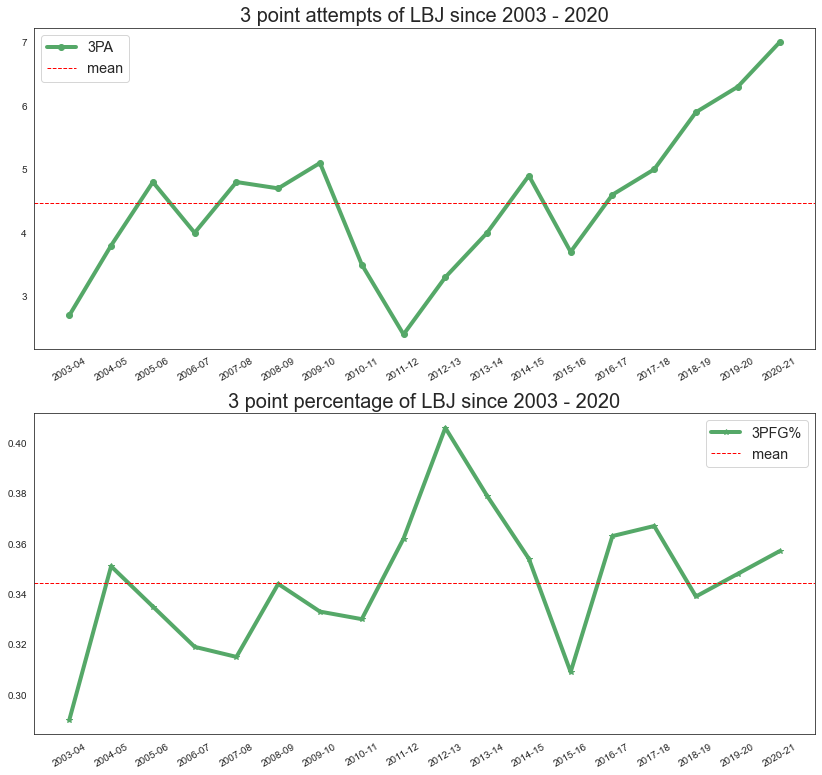

In [17]:
plt.figure(figsize=(14,13))

plt.subplot(211)
plt.plot(lbj_season,lbj_3pa,'-g',linewidth=4, marker = 'o')
plt.title('3 point attempts of LBJ since 2003 - 2020', fontsize = 20)
plt.axhline(y=lbj_3pa.mean(), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30) 
plt.legend(('3PA', 'mean'), fontsize='x-large')

plt.subplot(212)
plt.plot(lbj_season,lbj_3pct,'-g',linewidth=4, marker = '*')
plt.title('3 point percentage of LBJ since 2003 - 2020', fontsize = 20)
plt.axhline(y=lbj_3pct.mean(), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30) 
plt.legend(('3PFG%', 'mean'), fontsize='x-large')
           
plt.show() # 추후에 리그평균 추가

*  르브론은 3점슛 시도를 이전보다 늘려왔다. 3점을 많이 쏘는 농구 트렌드의 변화와 노쇠화로 인해 3점 시도가 늘어났을 것이다.   
*  한편 3점슛 성공률은 평균적으로 어느정도 증가하였으나 일정한 수준을 유지하고 있다. 3점 슛시도는 증가하고 이에 대한 성공률은 일정하므로 3점을 활용한 공격 효율이 좋아졌음을 확인할 수 있다

-----------------------------------------

source : https://github.com/hkair/nba-shotcharts